In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr, spearmanr

# Choosing the PCOS dataset
- `pcosyang2024`: individual data meta analysis on 14 cohort studies
- ~~`pcosli2023`: systematic review and meta analysis on 28 studies~~
- ~~`pcossolaleyva2023`: systematic review and meta analysis on 17 gut microbe studies (investigated oral cavity, blood, vagina/cervix, gut sites)~~

The latter two reviews do not contain the individual level data directly and will require some work on our part to analyze the raw sequencing data. 

In [2]:
# pcosyang2024

pcosyang2024 = pd.read_excel("../data/raw/pcosyang2024.xlsx", engine="openpyxl")
pcosyang2024

,sample,SRR4457864,SRR4457873,SRR4457876,SRR4457877,SRR4457878,SRR4457879,SRR4457880,SRR4457881,SRR4457882,...,SRR24874396,SRR24874397,SRR24874398,SRR24874399,SRR24874400,SRR24874401,SRR24874402,SRR24874404,SRR24874405,SRR24874406
0,group,HC,HC,HC,HC,HC,HC,HC,HC,HC,...,PCOS,PCOS,PCOS,PCOS,PCOS,PCOS,PCOS,PCOS,PCOS,PCOS
1,region,Europe,Europe,Europe,Europe,Europe,Europe,Europe,Europe,Europe,...,Asia,Asia,Asia,Asia,Asia,Asia,Asia,Asia,Asia,Asia
2,T,HC,HC,HC,HC,HC,HC,HC,HC,HC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01D2Z36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0319-6G20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,Yersinia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128,Youngiibacter,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1129,Zavarzinia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1130,Zoogloea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# transpose and set columns

pcostest = pcosyang2024.T
pcostest.columns = pcostest.iloc[0, :]
pcostest = pcostest.iloc[1:, :]
pcostest

sample,group,region,T,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,...,WPS-2,WWH38,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006
SRR4457864,HC,Europe,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457873,HC,Europe,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457876,HC,Europe,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457877,HC,Europe,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457878,HC,Europe,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR24874401,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874402,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874404,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874405,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# investigate region and T columns

pcostest.groupby(['group', 'region', 'T']).count().iloc[:, 1]

group  region  T 
HC     Asia    HC    237
       Europe  HC    198
PCOS   Asia    HT    275
               LT     20
       Europe  HT    141
               LT     24
Name: 0319-6G20, dtype: int64

In [5]:
# investigate nans

pcostest.isna().sum().sort_values(ascending=False)

sample
T                                      53
group                                   0
Paenalcaligenes                         0
Paludibacter                            0
Pajaroellobacter                        0
                                       ..
Ethanoligenens                          0
Eubacterium                             0
Eubacterium_brachy_group                0
Eubacterium_coprostanoligenes_group     0
ZOR0006                                 0
Length: 1132, dtype: int64

In [6]:
# investigate nans in the testosterone column (should be reported for all PCOS patients unless some study did not track this?)

pcostest[pcostest['T'].isna()]

sample,group,region,T,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,...,WPS-2,WWH38,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006
SRR23476464,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR23476465,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0038
SRR23476466,PCOS,Asia,NaN,0,0,0,0,0,0,0.113559,...,0,0,0,0,0,0,0,0,0,0
SRR23476472,PCOS,Asia,NaN,0,0,0,0,0,0,0.093711,...,0,0,0,0,0,0,0,0,0,0
SRR23476473,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR23476474,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR23476475,PCOS,Asia,NaN,0,0,0.023762,0.00396,0,0,0,...,0.029703,0.015842,0,0,0,0,0,0,0,0
SRR23476476,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR23476477,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR23476478,PCOS,Asia,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# figure out if we can deciper which study a sample came from
pcostest[pcostest['region'] == 'Asia'].iloc[0:50]

sample,group,region,T,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,...,WPS-2,WWH38,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006
SRR20852732,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852733,HC,Asia,HC,0,0,0,0,0,0,0.077188,...,0,0,0,0,0,0,0,0,0,0
SRR20852735,HC,Asia,HC,0,0,0,0,0,0,0.355691,...,0,0,0,0,0,0,0,0,0,0
SRR20852736,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852737,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852738,HC,Asia,HC,0,0,0,0,0,0,0.005756,...,0,0,0,0,0,0,0,0,0,0
SRR20852746,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852747,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852748,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR20852749,HC,Asia,HC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# split based on group

pcostesthc = pcostest[pcostest['group'] == 'HC']
pcostestpcos = pcostest[pcostest['group'] == 'PCOS']

## Feature Shrinking | Option 1: Logistic LASSO

In [15]:
def run_logistic_lasso(random_state):
    # a) use a holdout sample for training logistic lasso
    # pcostestloglasso = pd.concat([pcostesthc.sample(100, random_state=random_state), pcostestpcos.sample(100, random_state=random_state)])
    # b) or, use the entire sample for training logistic lasso
    pcostestloglasso = pd.concat([pcostesthc, pcostestpcos])

    # logistic regression inputs
    X = pcostestloglasso
    X['region'] = X['region'].apply(lambda x: 0 if x == 'Europe' else 1)
    X = X.iloc[:, 1:]
    X = X.drop(columns=['T'])
    
    Y = pcostestloglasso['group'].apply(lambda x: 0 if x == 'HC' else 1)

    # smaller Cs = stronger regularization
    model = LogisticRegressionCV(
        Cs = np.linspace(0.01, 1, 20),
        max_iter = 10000,
        cv = StratifiedKFold(5, shuffle = True, random_state=random_state),
        penalty='l1',
        solver='liblinear')
    
    model_def = LogisticRegressionCV(
        Cs = 20,
        cv = StratifiedKFold(5, shuffle = True, random_state=random_state),
        max_iter = 10000,
        penalty='l1',
        solver='liblinear')
    
    model.fit(X, Y)
    model_def.fit(X, Y)

    def no_nonzero_covariates(coef):
        return np.sum(np.abs(coef) != 0)

    print("Constrained-Cs-below-1 model")
    print("... Number of Nonzero Covariates: ", no_nonzero_covariates(model.coef_))
    print("... Best C: ", model.C_)
    print("... Model Score On Full Training: ", model.score(X, Y), "\n")
    print("Default-Cs model")
    print("... Number of Nonzero Covariates: ", no_nonzero_covariates(model_def.coef_))
    print("... Best C: ", model_def.C_)
    print("... Model Score on Full Training: ", model_def.score(X, Y))
        

In [16]:
def test_diff_random_state(seed_no):
    random.seed(seed_no)
    run_logistic_lasso(seed_no)
    print("\n\n")


test_diff_random_state(1)
# test_diff_random_state(100)
# test_diff_random_state(948)

/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn

Constrained-Cs-below-1 model
... Number of Nonzero Covariates:  119
... Best C:  [0.42684211]
... Model Score On Full Training:  0.7447257383966245 

Default-Cs model
... Number of Nonzero Covariates:  306
... Best C:  [29.76351442]
... Model Score on Full Training:  0.8860759493670886





In [17]:
test_diff_random_state(100)

/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.13/site-packages/sklearn

Constrained-Cs-below-1 model
... Number of Nonzero Covariates:  119
... Best C:  [0.42684211]
... Model Score On Full Training:  0.7447257383966245 

Default-Cs model
... Number of Nonzero Covariates:  131
... Best C:  [0.61584821]
... Model Score on Full Training:  0.7552742616033755





## Feature Shrinking | Option 2: Sure Independence Screening
Screening by ranking the correlation between outcome and each feature.

As per scipy docs, "For small samples, consider performing a permutation test instead of relying on the asymptotic p-value", where they define smaller sample sizes as <500.

In [19]:
X = pcostest
X['region'] = X['region'].apply(lambda x: 0 if x == 'Europe' else 1)
X = X.iloc[:, 1:]
X = X.drop(columns=['T'])

Y = pcostest['group'].apply(lambda x: 0 if x == 'HC' else 1)

In [21]:
X.iloc[:10]

sample,region,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,Abiotrophia,Absconditabacteriales_(SR1),...,WPS-2,WWH38,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006
SRR4457864,0,0,0,0,0,0,0,0,0,0.019341,...,0,0,0,0,0,0,0,0,0,0
SRR4457873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457877,0,0,0,0,0,0,0,0,0,0.010694,...,0,0,0,0,0,0,0,0,0,0
SRR4457878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
# Pearson
pearsonr_df = pd.DataFrame({'Column': [], 'Pearson R': [], 'p value': []})
for col in X.columns:
    result = pearsonr(X[col].astype(float), Y)
    pearsonr_df = pd.concat([pearsonr_df, pd.DataFrame({'Column': [col], 'Pearson R': [np.abs(result[0])], 'p value': [result[1]]})])

pearsonr_df = pearsonr_df.reset_index(drop=True)
pearsonr_df.sort_values(by='Pearson R', ascending=False)

/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_85619/975097731.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = pearsonr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_85619/975097731.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = pearsonr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_85619/975097731.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = pearsonr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_85619/975097731.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = pearsonr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_85619/975097731.py:4: ConstantInputWarning: An input array is

,Column,Pearson R,p value
173,Burkholderia,0.158051,0.000001
905,Ruminococcus,0.156155,0.000001
252,Clostridia_UCG-014,0.150690,0.000003
1083,UCG-005,0.144898,0.000007
907,Ruminococcus_gnavus_group,0.141962,0.000011
...,...,...,...
911,Runella,NaN,NaN
1031,Tepidimicrobium,NaN,NaN
1112,W5053,NaN,NaN
1115,Weeksella,NaN,NaN


In [62]:
# how many nulls?
pearsonr_df['Pearson R'].isna().sum() # 29 nulls

np.int64(29)

(array([195., 343., 268., 163.,  63.,  37.,  18.,   5.,   5.,   4.]),
 array([6.41919063e-07, 1.58056366e-02, 3.16106313e-02, 4.74156260e-02,
        6.32206207e-02, 7.90256154e-02, 9.48306100e-02, 1.10635605e-01,
        1.26440599e-01, 1.42245594e-01, 1.58050589e-01]),
 <BarContainer object of 10 artists>)

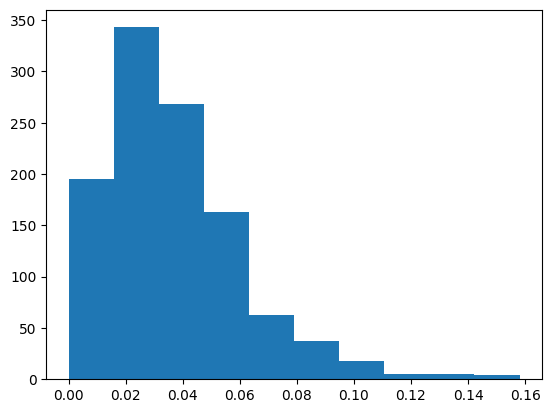

In [63]:
# how distributed?
plt.hist(pearsonr_df['Pearson R'])

In [73]:
# take top 20? 25?
pearsonr_df.sort_values(by='Pearson R', ascending=False).iloc[0:30].reset_index(drop=True)

,Column,Pearson R,p value
0,Burkholderia,0.158051,0.000001
1,Ruminococcus,0.156155,0.000001
2,Clostridia_UCG-014,0.150690,0.000003
3,UCG-005,0.144898,0.000007
4,Ruminococcus_gnavus_group,0.141962,0.000011
5,Holdemanella,0.137129,0.000023
6,Bacteroides,0.134695,0.000032
7,Kineothrix,0.131059,0.000052
8,UCG-010,0.127210,0.000086
9,Flintibacter,0.126250,0.000097


In [28]:
# Spearman
spearmanr_df = pd.DataFrame({'Column': [], 'Spearman R': [], 'p value': []})
for col in X.columns:
    result = spearmanr(X[col].astype(float), Y)
    spearmanr_df = pd.concat([spearmanr_df, pd.DataFrame({'Column': [col], 'Spearman R': [np.abs(result[0])], 'p value': [result[1]]})])

spearmanr_df = spearmanr_df.reset_index(drop=True)
spearmanr_df.sort_values(by='Spearman R', ascending=False)

/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_1559/3215189284.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spearmanr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_1559/3215189284.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spearmanr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_1559/3215189284.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spearmanr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_1559/3215189284.py:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  result = spearmanr(X[col].astype(float), Y)
/var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/ipykernel_1559/3215189284.py:4: ConstantInputWarning: An input arra

,Column,Spearman R,p value
905,Ruminococcus,0.226328,1.775719e-12
907,Ruminococcus_gnavus_group,0.216238,1.709887e-11
146,Bilophila,0.163554,4.121820e-07
673,Millionella,0.163436,4.202545e-07
1087,UCG-010,0.163299,4.298213e-07
...,...,...,...
911,Runella,NaN,NaN
1031,Tepidimicrobium,NaN,NaN
1112,W5053,NaN,NaN
1115,Weeksella,NaN,NaN


In [30]:
# how many nulls?
spearmanr_df[spearmanr_df['Spearman R'].isna()]

,Column,Spearman R,p value
18,Acholeplasma,NaN,NaN
19,Acidaminobacter,NaN,NaN
133,Bacteroidales_RF16_group,NaN,NaN
172,Bulleidia,NaN,NaN
185,Calderihabitans,NaN,NaN
266,Clostridium_XVIII,NaN,NaN
279,Corallococcus,NaN,NaN
410,Falsarthrobacter,NaN,NaN
411,Falsirhodobacter,NaN,NaN
462,Geopsychrobacter,NaN,NaN


(array([519., 377., 115.,  37.,  27.,  13.,   7.,   4.,   0.,   2.]),
 array([7.97751608e-06, 2.26399871e-02, 4.52719968e-02, 6.79040064e-02,
        9.05360160e-02, 1.13168026e-01, 1.35800035e-01, 1.58432045e-01,
        1.81064054e-01, 2.03696064e-01, 2.26328074e-01]),
 <BarContainer object of 10 artists>)

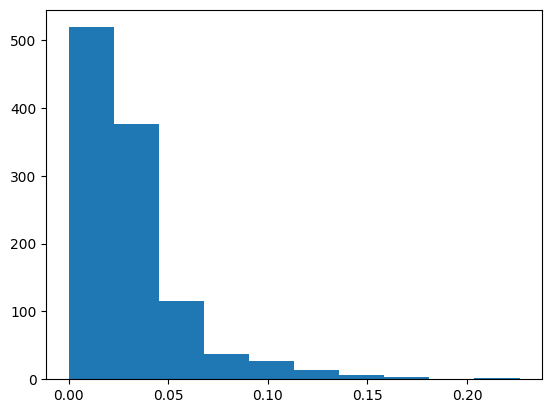

In [67]:
# how distribued?
plt.hist(spearmanr_df['Spearman R'])

In [38]:
np.sqrt(np.log(1129)/948)

np.float64(0.08610835806860909)

In [37]:
spearmanr_df[spearmanr_df['Spearman R'] > np.sqrt(np.log(1129)/948)].sort_values(by='Spearman R', ascending=False).shape

(58, 3)

In [74]:
# take top 20? 25?
spearmanr_df.sort_values(by='Spearman R', ascending=False).iloc[0:30].reset_index(drop=True)

,Column,Spearman R,p value
0,Ruminococcus,0.226328,1.775719e-12
1,Ruminococcus_gnavus_group,0.216238,1.709887e-11
2,Bilophila,0.163554,4.121820e-07
3,Millionella,0.163436,4.202545e-07
4,UCG-010,0.163299,4.298213e-07
5,Holdemanella,0.161697,5.586502e-07
6,Clostridia_UCG-014,0.157187,1.152677e-06
7,Lachnospiraceae_UCG-008,0.142361,1.083022e-05
8,Christensenellaceae_R-7_group,0.141988,1.142786e-05
9,Eggerthella,0.141987,1.142835e-05


In [42]:
X

sample,region,01D2Z36,0319-6G20,0319-7L14,27F-1492R,37-13,67-14,A2,Abiotrophia,Absconditabacteriales_(SR1),...,WPS-2,WWH38,Xanthomonas,Xenorhabdus,Xylanibacillus,Yersinia,Youngiibacter,Zavarzinia,Zoogloea,ZOR0006
SRR4457864,0,0,0,0,0,0,0,0,0,0.019341,...,0,0,0,0,0,0,0,0,0,0
SRR4457873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR4457877,0,0,0,0,0,0,0,0,0,0.010694,...,0,0,0,0,0,0,0,0,0,0
SRR4457878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR24874401,1,0,0,0,0,0,0,0,0.009899,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874402,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874404,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR24874405,1,0,0,0,0,0,0,0,0.050805,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X.iloc[0].sort_values()

sample
region                              0
OLB14                               0
Oligella                            0
Olivibacter                         0
Olsenella                           0
                              ...    
Eubacterium_hallii_group     7.874187
Blautia                      8.553538
Alistipes                    9.552015
Faecalibacterium            10.381259
Bacteroides                 12.646568
Name: SRR4457864, Length: 1130, dtype: object

In [ ]:
# Combination of Pearson & Spearman based on linearity?

# SCRATCH

In [ ]:
# create holdout dataset to train logistic regression model w/ LASSO penalty

pcostesthc = pcostest[pcostest['group'] == 'HC']
pcostestpcos = pcostest[pcostest['group'] == 'PCOS']
pcostestloglasso = pd.concat([pcostesthc.sample(100), pcostestpcos.sample(100)])

In [ ]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)

In [ ]:
# numerize all other variables, create feature matrix

X = pcostestloglasso
X['region'] = X['region'].apply(lambda x: 0 if x == 'Europe' else 1)
X = X.iloc[:, 1:]
X = X.drop(columns=['T'])
X

In [32]:
def check_linearity_large(data):
    '''
    Plots scatter plots of all pairs of the variables in the dataset to check for linearity. Saves them in the plots folder as "many_scatter.png".

    :param: data: clean dataset
    '''
    X = data.copy()
    pairs_X = list(itertools.combinations(X.columns, 2))
    
    num_rows = len(pairs_X) // 5
    # fig, axs = plt.subplots(num_rows, 5, figsize=(20, num_rows * 3))
    # fig.suptitle('Pairwise Scatter Plots for Linearity in Data')

    # axs = axs.ravel()

    # for i in range(len(pairs_X)):
    for i in range(len(pairs_X)):
        fig, ax = plt.subplots()
        x = pairs_X[i][0]
        y = pairs_X[i][1]
        # axs[i].scatter(x = X[x], y = X[y])
        # axs[i].set_xlabel(x)
        # axs[i].set_ylabel(y)
        ax.scatter(x = X[x], y = X[y])
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.set_title(f"Scatter plot of {x} and {y}")
        # fig.savefig(f"plots/{x}_{y}_scatter.png")
        plt.show()
        
    # fig.subplots_adjust(top=0.975, wspace=0.2, hspace=0.15)
    # fig.savefig("plots/many_scatter.png")
    # plt.close(fig)

    return


def check_gaussianity_large(data):
    '''
    Plots qq plots of all genera to check for Gaussianity. Saves each of them in the plots folder by their genus name. 

    :param: data: clean gut abundance dataset with genera only
    '''
    X = data.copy()

    for i in range(len(X.columns)):
        fig, ax = plt.subplots()
        sm.qqplot(X.iloc[:, i], line='q', ax=ax)
        ax.set_title(X.columns[i])
        # fig.savefig(f"plots/{X.columns[i]}_qqplot.png")
        plt.show()

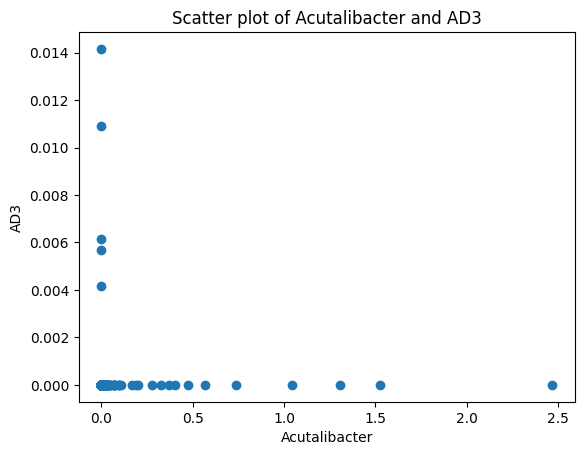

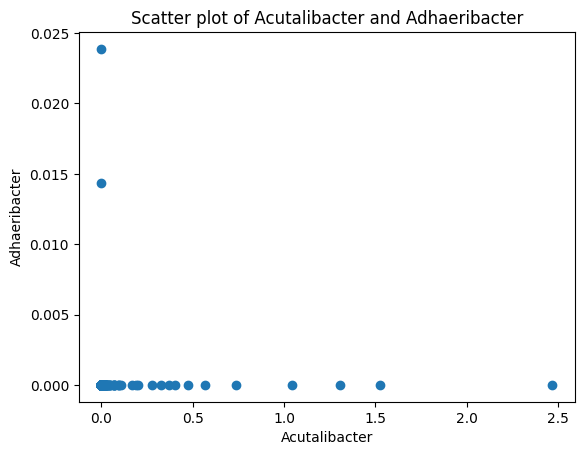

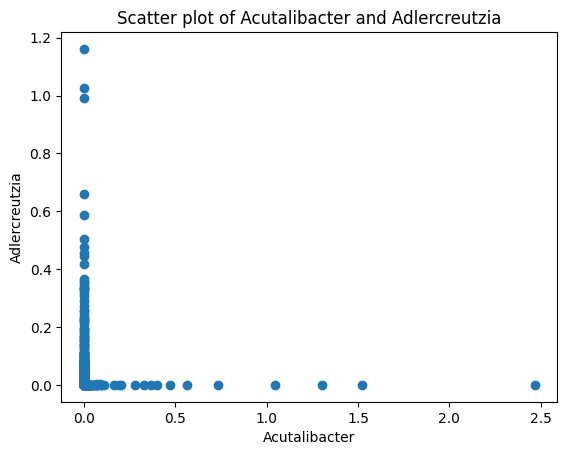

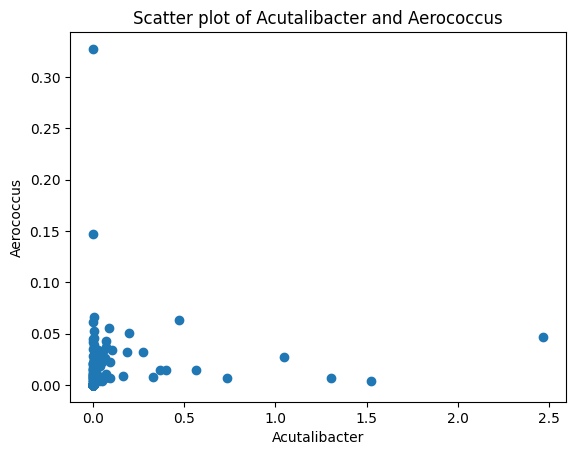

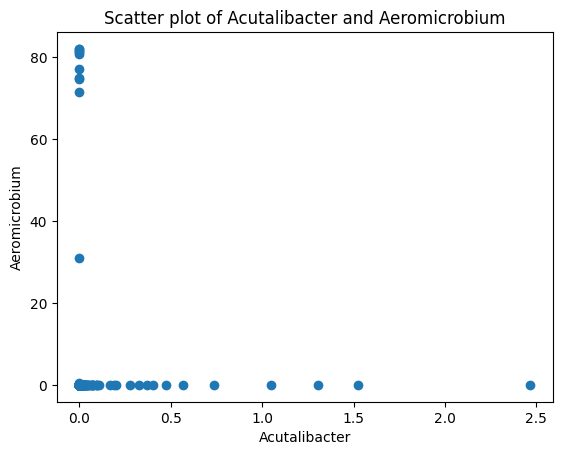

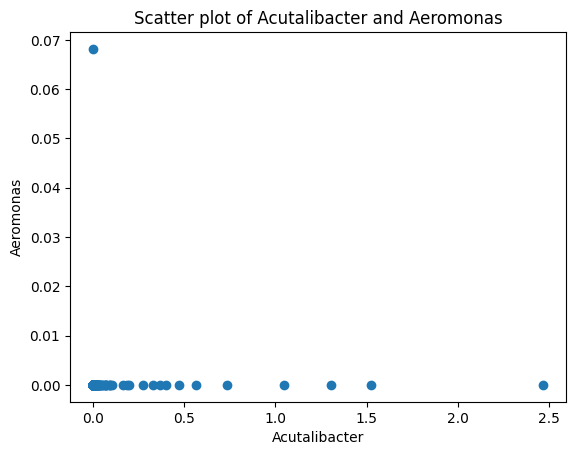

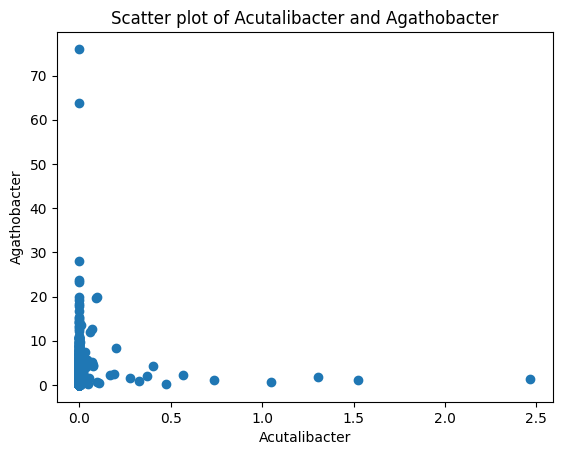

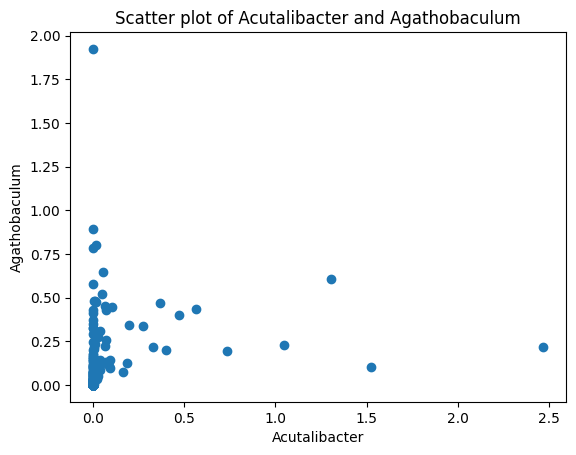

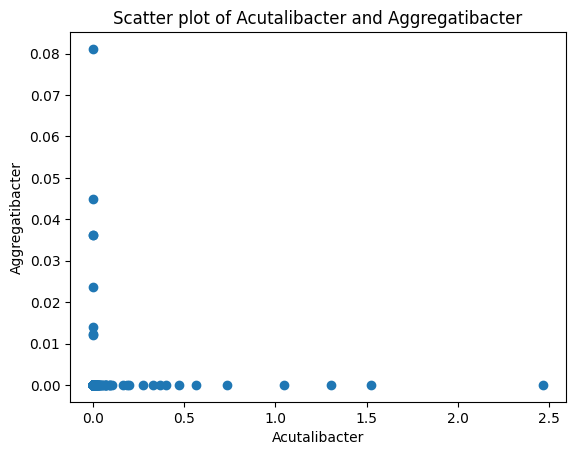

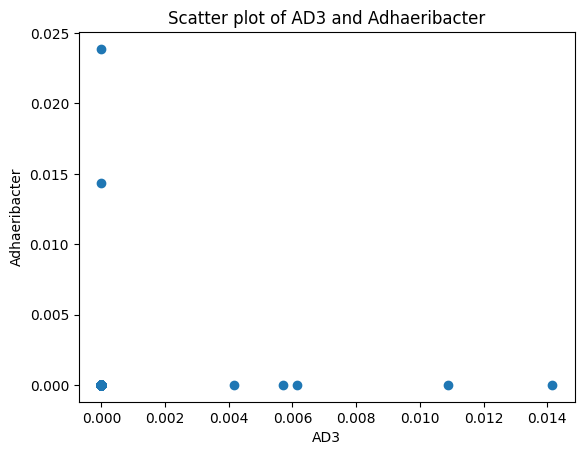

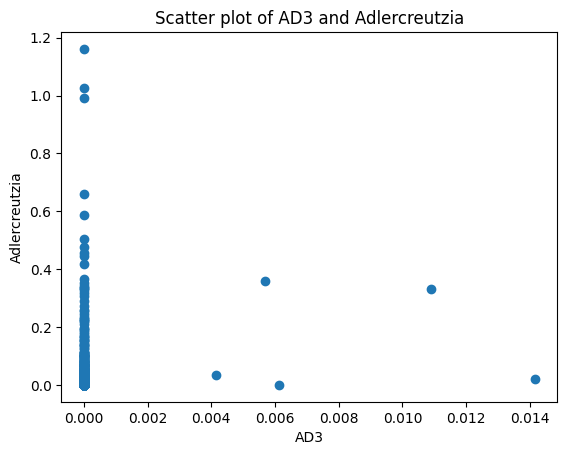

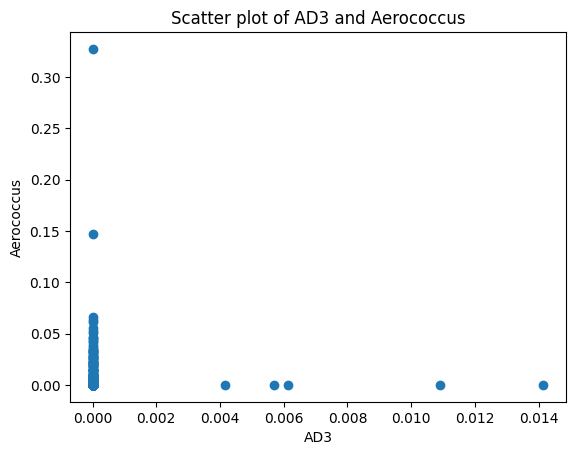

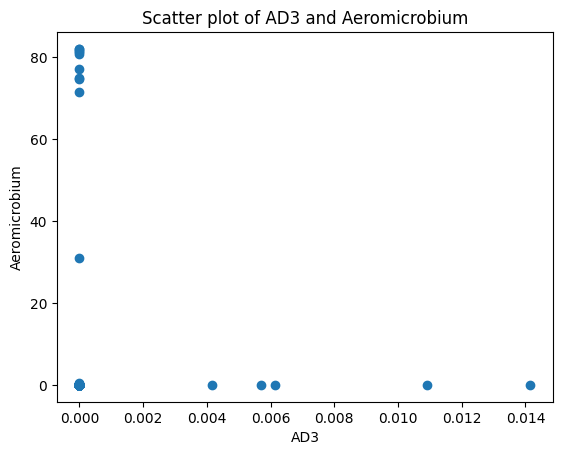

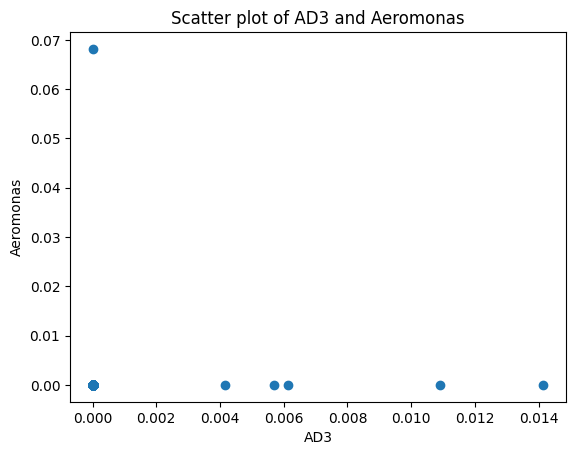

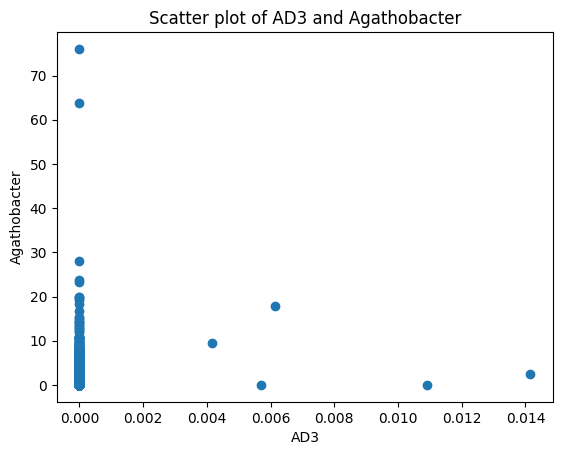

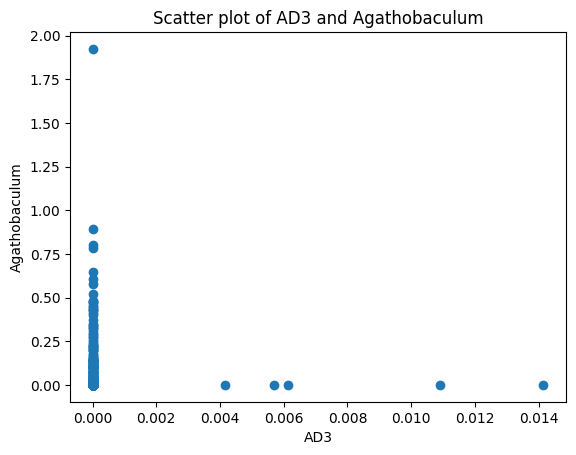

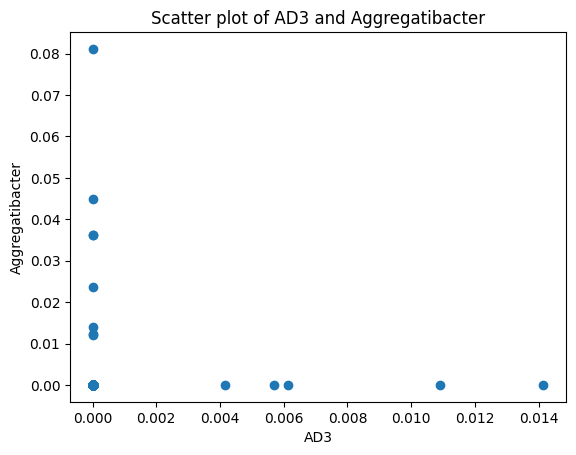

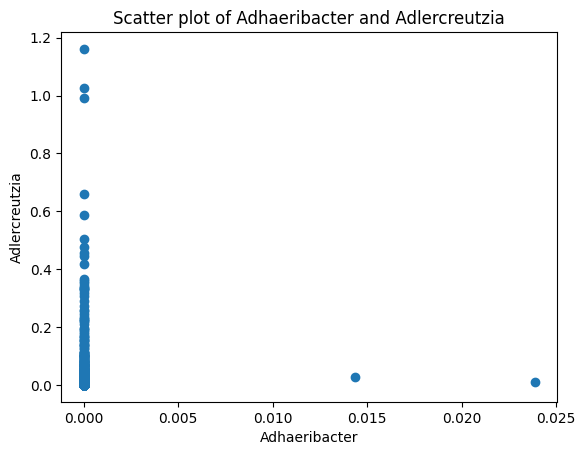

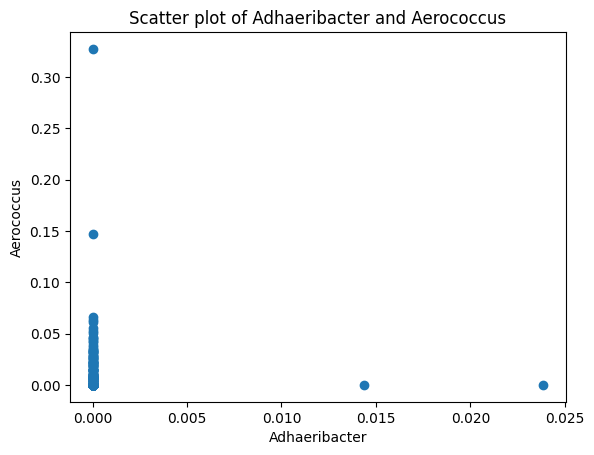

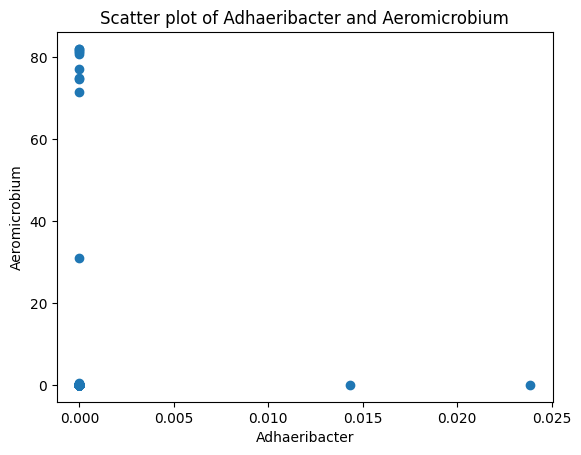

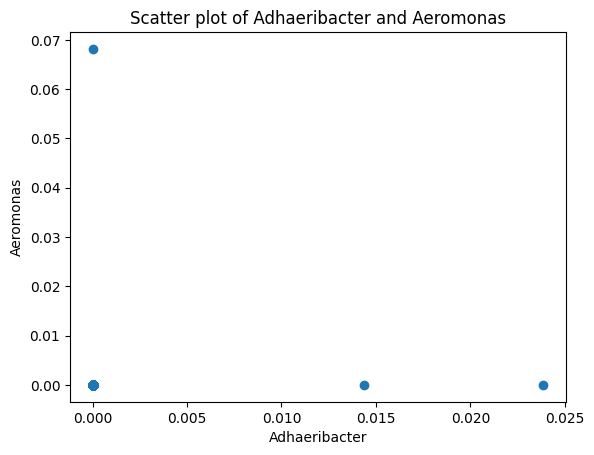

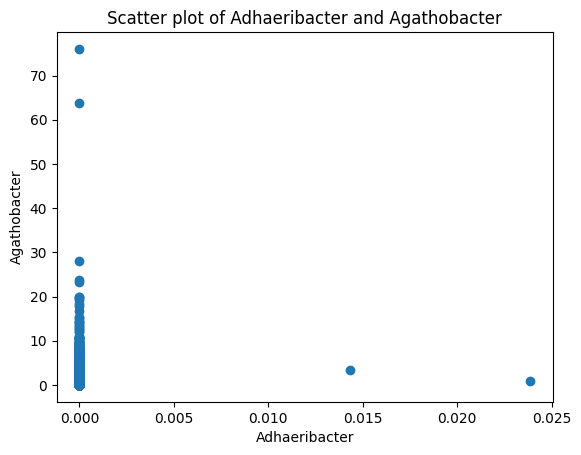

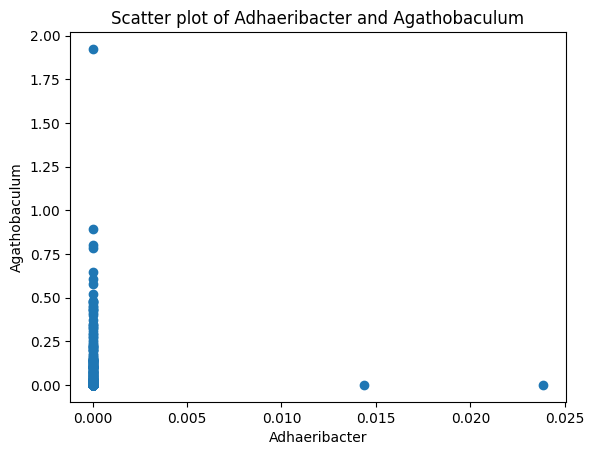

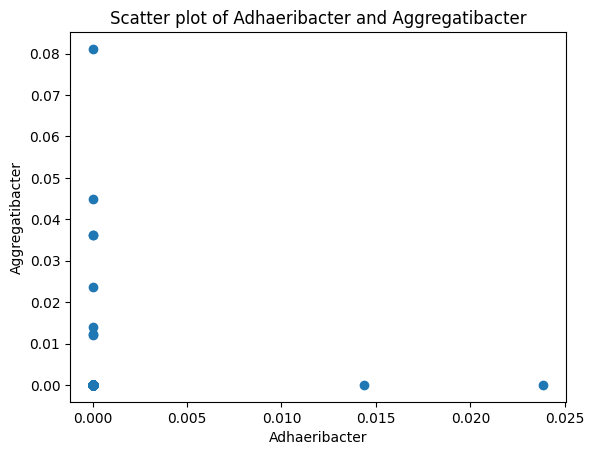

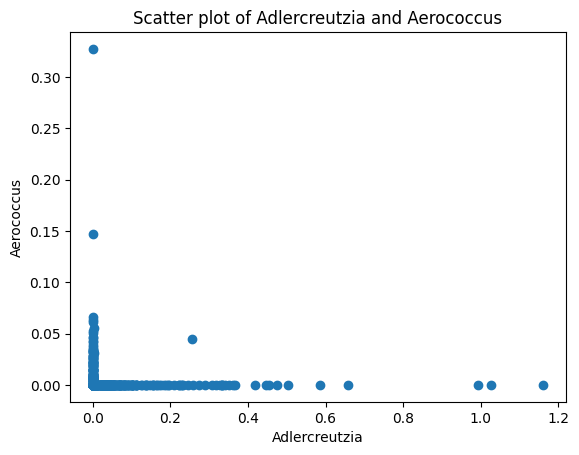

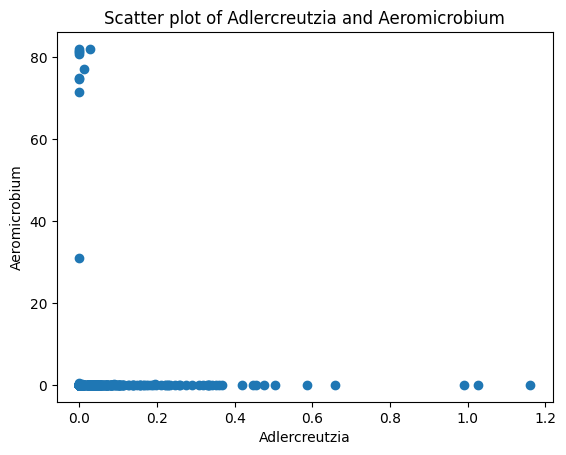

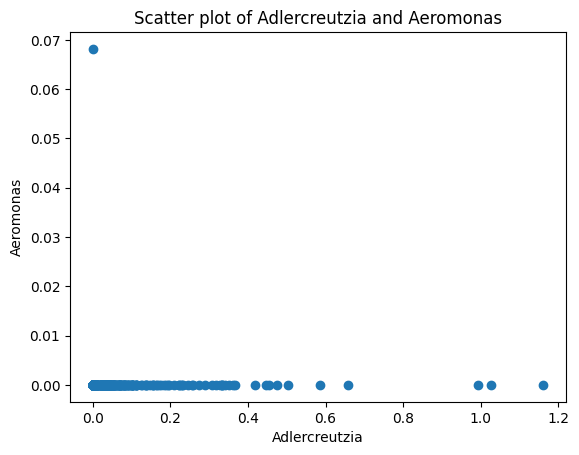

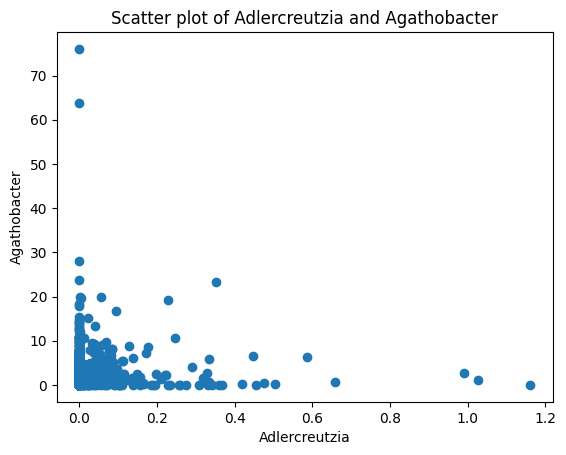

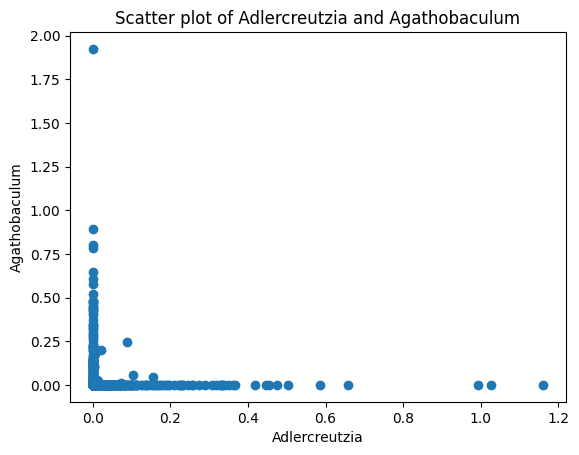

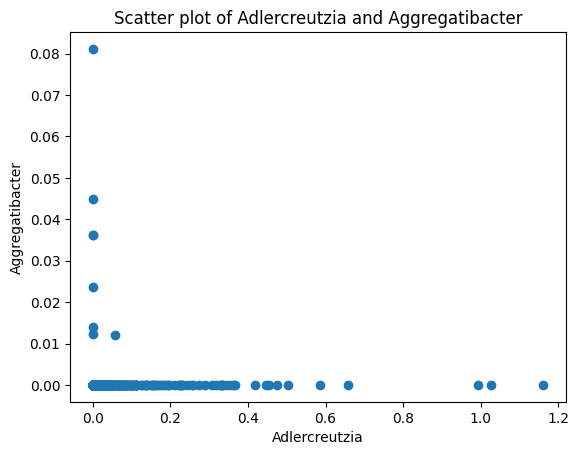

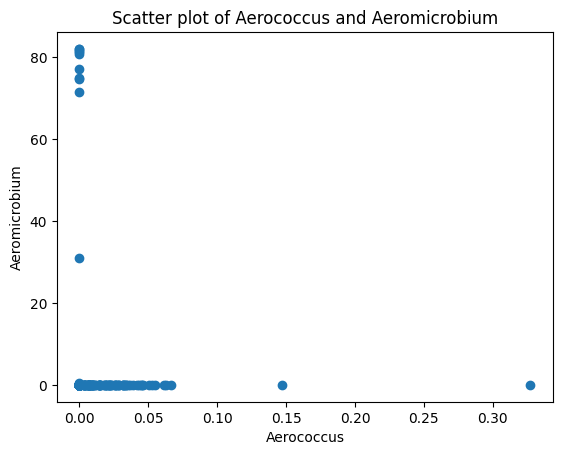

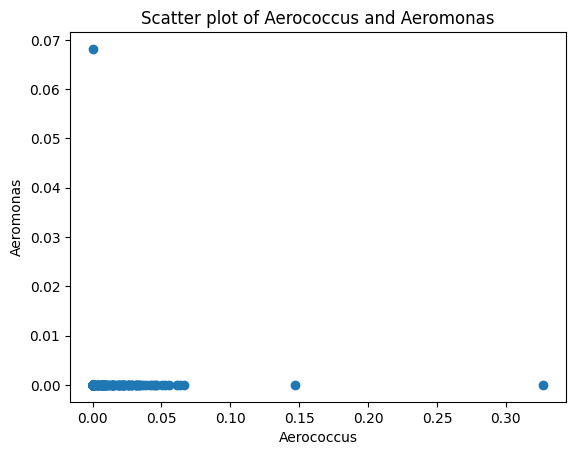

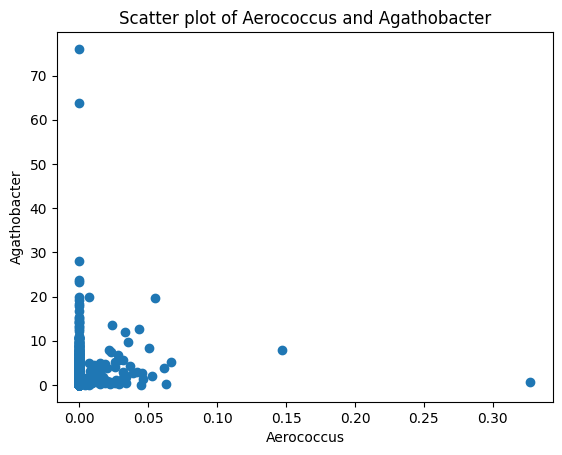

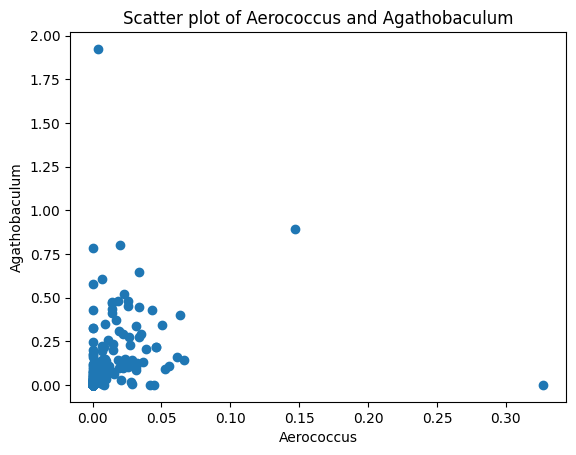

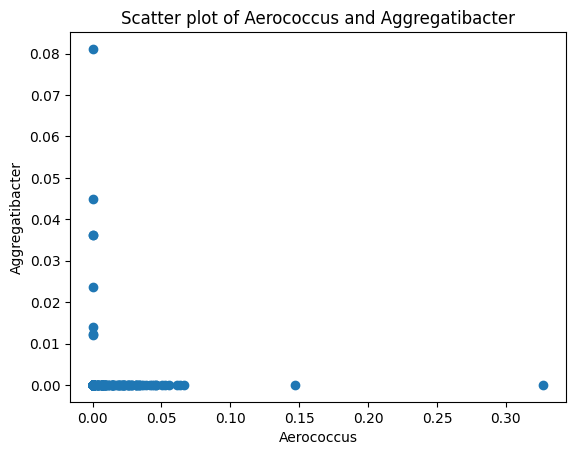

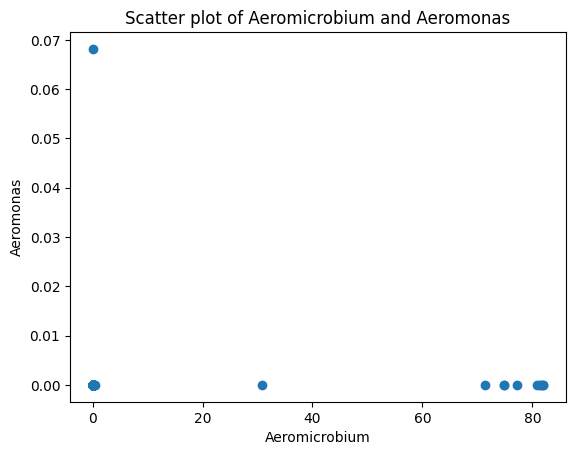

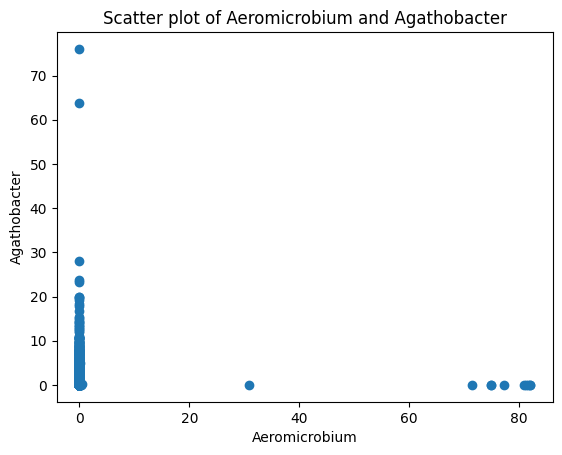

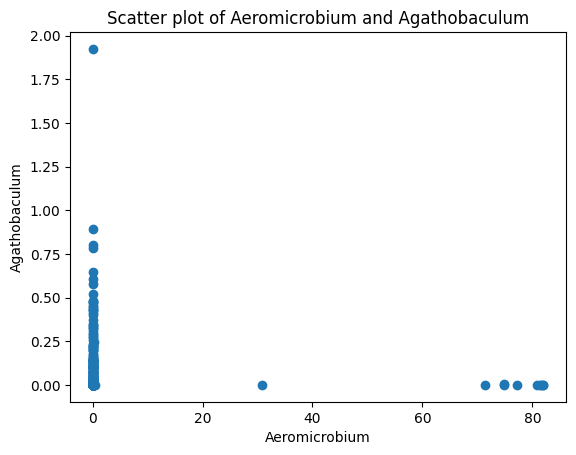

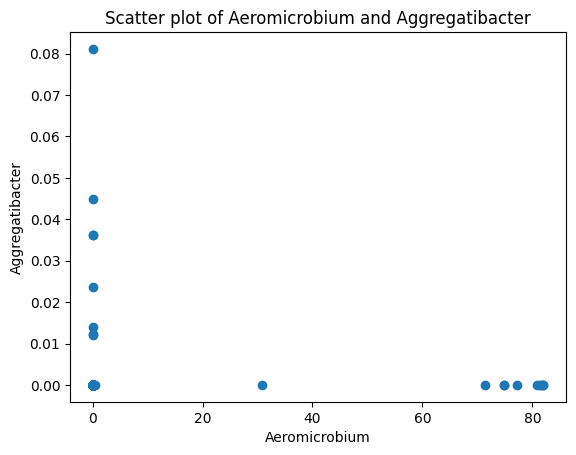

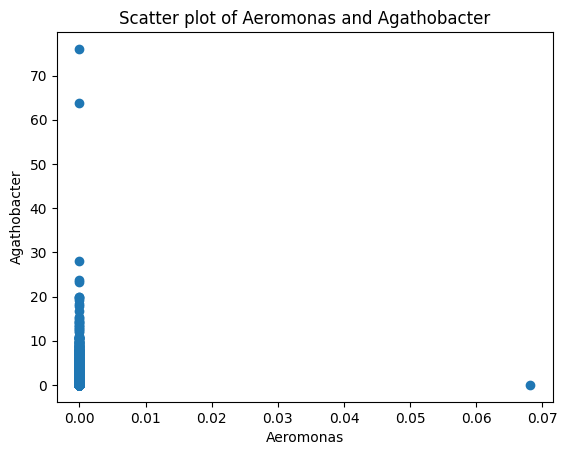

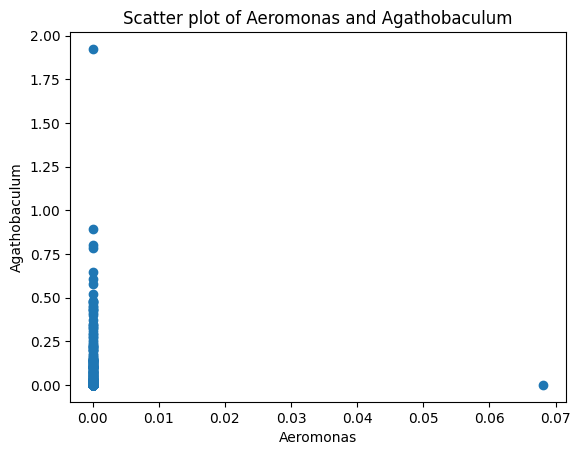

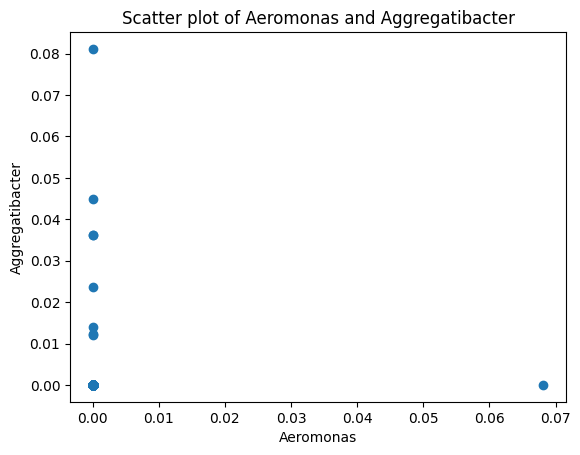

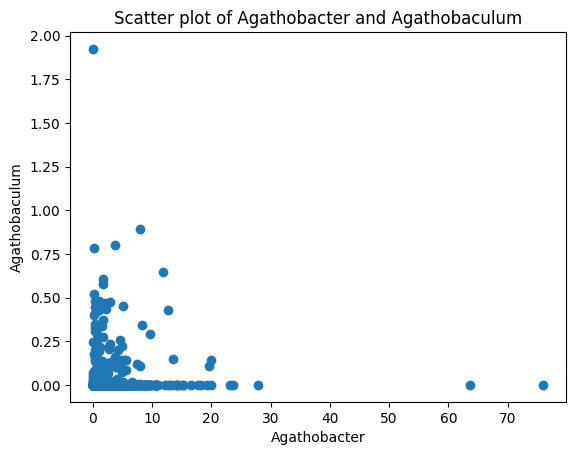

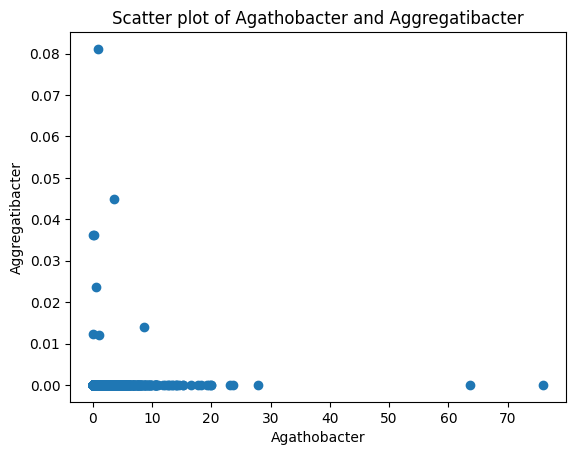

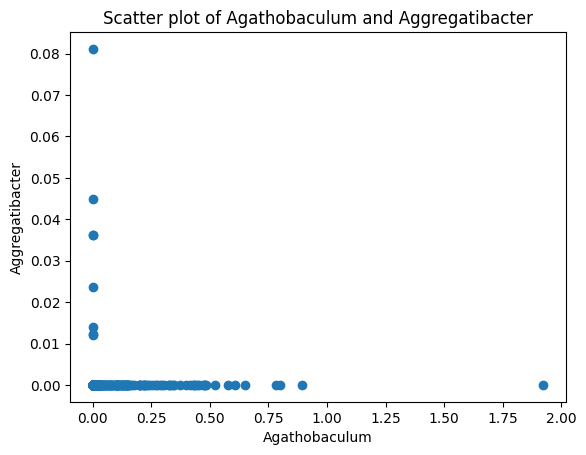

In [33]:
check_linearity_large(X.iloc[:, 30:40])

In [ ]:
check_gaussianity_large(X.iloc[:, 30:40])

In [ ]:
def make_corr_plot(data, squared=False):
    corr = data.corr()
    if squared:
        corr = corr**2
    full_columns = list(data.columns)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot()
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax, fraction=0.046, pad=0.04)

    xaxis = np.arange(len(full_columns))
    ax.set_xticks(xaxis, labels=full_columns, fontsize=12)
    ax.set_yticks(xaxis, labels=full_columns, fontsize=12)

    plt.setp(ax.get_xticklabels(), rotation=-60, ha="right", rotation_mode="anchor")

    return 

In [ ]:
make_corr_plot(pcostest.iloc[:, 30:60])

In [ ]:
# numerize outcome vector

Y = pcostestloglasso['group'].apply(lambda x: 0 if x == 'HC' else 1)
Y

In [ ]:
# run logistic regression with l1 penalty (LASSO on classification)

# smaller Cs = stronger regularization
model = LogisticRegressionCV(
    Cs = np.linspace(0.01, 1, 20),
    max_iter = 10000,
    cv = 5,
    penalty='l1',
    solver='liblinear')

model_def = LogisticRegressionCV(
    Cs = 20,
    cv = 5,
    max_iter = 10000,
    penalty='l1',
    solver='liblinear')

model.fit(X, Y)
model_def.fit(X, Y)

In [ ]:
# number of nonzero covariates

def no_nonzero_covariates(coef):
    return np.sum(np.abs(coef) != 0)

print("Constrained Cs below 1 model: ", no_nonzero_covariates(model.coef_))
print("... Best C: ", model.C_)
print("... Model Score On Full Training: ", model.score(X, Y))
print("Default Cs model: ", no_nonzero_covariates(model_def.coef_))
print("... Best C: ", model_def.C_)
print("... Model Score on Full Training: ", model_def.score(X, Y))

In [ ]:
model.score(X, Y)

In [ ]:
model.scores_

In [ ]:
model.Cs_

In [ ]:
model.C_

In [ ]:
loglassocoefs[loglassocoefs!=0]